In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Loading data
--

In [2]:
df_answers = pd.read_csv('answers.csv', names=['answer_id', 'answer_text', 'type', 'question_id', 'question_type'])
df_answers = df_answers[~df_answers.answer_id.isnull()].reset_index()

In [3]:
df_attempts = pd.read_csv('attempts.csv', names=['attempt_id', 'user_id', 'user_visit_number', 'question_id', 
                                                 'attempt_timestamp', 'answers_combo', 'clicked',
                                                 'reflection_time', 'is_right', 'answer_type', 'answer_id',
                                                 'lifetime_question_number', 'platform'])
df_attempts = df_attempts[~df_attempts.attempt_id.isnull()].reset_index()

In [4]:
df_questions = pd.read_csv('questions.csv', names=['question_id', 'difficulty', 'category_id', 'question_text', 
                                                 'question_image_id', 'answer_explanation', 'date_added'])
df_questions = df_questions[~df_questions.question_id.isnull()].reset_index()

In [5]:
df_users = pd.read_csv('users.csv', names=['user_id', 'dateCreated', 'location'])
df_users = df_users[~df_users.user_id.isnull()].reset_index()

In [6]:
df = pd.merge(df_users, df_attempts, on='user_id')
df = pd.merge(df, df_questions, on='question_id')
df = pd.merge(df, df_answers, on='question_id')

Clean up data
--

Throw out attempts records when the user did not answer the question at all

In [7]:
df = df[df.clicked > 0]

Count user attemtps

In [8]:
usr_att_count = pd.DataFrame({'att_num': df.groupby('user_id').attempt_id.count()}).reset_index()

Throw users with less than 10 attempts total

In [9]:
usr_att_count = usr_att_count[usr_att_count.att_num >= 10]
df = pd.merge(df, usr_att_count, on='user_id')

Count user right answers

In [10]:
usr_right_count = pd.DataFrame({'right_num': df[df.is_right == 1].groupby('user_id').attempt_id.count()}).reset_index()

Drop users with less than 30% right answers

In [11]:
df_att_right_count = pd.merge(usr_att_count, usr_right_count, on='user_id')
df_att_right_count['perc_right'] = df_att_right_count.right_num / df_att_right_count.att_num
df_att_right_count = df_att_right_count[df_att_right_count.perc_right >= .3]
df = pd.merge(df, df_att_right_count, on='user_id')

Clean up summary
--

There are 3689776 in cleaned up data

In [12]:
len(df)

3689776

Plot histogram of user attempts count

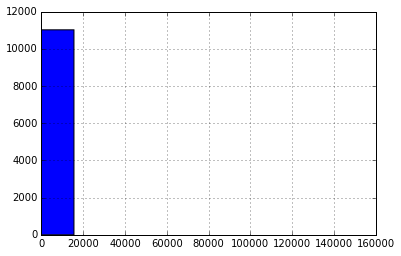

In [13]:
usr_att_count.att_num.hist()

Well, it's not much representative. Maybe, cutting the tails should help.

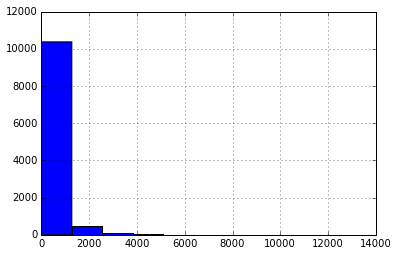

In [14]:
usr_att_count[usr_att_count.att_num < 20000].att_num.hist()

Not much better. Let's look at logscale.

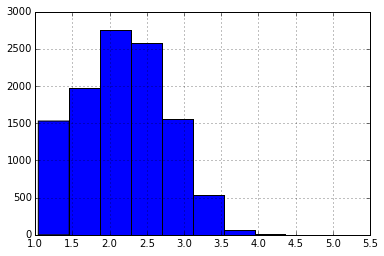

In [15]:
usr_att_count.att_num.apply(np.log10).hist()

In [16]:
np.log10(10)

1.0

Well, that's much better. We can see, that histogram starts somewhere near log10(10) (which is 1) -- as expected.

Add column for isUS location

In [17]:
df['isUS'] = df.location.apply(lambda x: 1 if x == 'United States' else 0)

Count US and non US attempts

In [18]:
local_attempts_df = pd.merge(pd.DataFrame({'US_attempts': df[df.isUS == 1].groupby('question_id').question_id.count()}).reset_index(),
                             pd.DataFrame({'non_US_attempts': df[df.isUS == 0].groupby('question_id').question_id.count()}).reset_index(),
                             on='question_id')
local_attempts_df = pd.merge(local_attempts_df, 
                             pd.DataFrame({'total_attempts': df.groupby('question_id').question_id.count()}).reset_index(),
                             on='question_id')
local_attempts_df

,question_id,US_attempts,non_US_attempts,total_attempts
0,1,210,63,273
1,2,287,98,385
2,3,217,63,280
3,4,329,91,420
4,5,196,35,231
5,6,238,105,343
6,7,266,147,413
7,8,217,140,357
8,9,259,70,329
9,10,231,77,308


Analysis
--

In [19]:
local_attempts_df = pd.merge(local_attempts_df, 
                             pd.DataFrame({'right_answers_US': df[(df.isUS == 1) & (df.is_right == 1)].groupby('question_id').question_id.count()}).reset_index(),
                             on='question_id')

local_attempts_df = pd.merge(local_attempts_df, 
                             pd.DataFrame({'right_answers_non_US': df[(df.isUS == 0) & (df.is_right == 1)].groupby('question_id').question_id.count()}).reset_index(),
                             on='question_id')

In [20]:
local_attempts_df = pd.merge(local_attempts_df, 
                             df_questions[['question_id', 'question_text']],
                             on='question_id')

local_attempts_df = pd.merge(local_attempts_df, 
                             df_answers[df_answers['type'] == 'R'][['question_id', 'answer_text']],
                             on='question_id')

In [21]:
local_attempts_df['right_perc_US'] = local_attempts_df.right_answers_US / local_attempts_df.US_attempts
local_attempts_df['right_perc_non_US'] = local_attempts_df.right_answers_non_US / local_attempts_df.non_US_attempts

In [22]:
local_attempts_df['right_perc_difference'] = local_attempts_df.right_perc_US - local_attempts_df.right_perc_non_US

In [23]:
cols = ['question_id', 'question_text', 'answer_text', 'US_attempts', 'non_US_attempts', 'total_attempts', 'right_answers_US', 'right_perc_US', 'right_answers_non_US', 'right_perc_non_US', 'right_perc_difference']

In [24]:
local_attempts_df = local_attempts_df[cols].sort('right_perc_difference', ascending=False)
local_attempts_df

,question_id,question_text,answer_text,US_attempts,non_US_attempts,total_attempts,right_answers_US,right_perc_US,right_answers_non_US,right_perc_non_US,right_perc_difference
9127,9512,Which food is necessary to make huevos rancheros?,Eggs,21,28,49,21,1.000000,7,0.250000,0.750000
5706,5821,What group of people actually elects the presi...,Electoral College,252,56,308,217,0.861111,7,0.125000,0.736111
226,232,Who accused later Supreme Court Justice Claren...,Anita Hill,336,84,420,266,0.791667,7,0.083333,0.708333
8965,9222,What company built the world's largest wagon t...,Radio Flyer,56,35,91,49,0.875000,7,0.200000,0.675000
6036,6163,What movie focuses on a town that outlaws danc...,<em>Footloose</em>,385,98,483,287,0.745455,7,0.071429,0.674026
9070,9376,Who flew the <em>Spirit of St. Louis</em>?,Charles Lindbergh,91,21,112,91,1.000000,7,0.333333,0.666667
1861,1887,Which US president is pictured on a $50 bill?,Ulysses S. Grant,371,112,483,266,0.716981,7,0.062500,0.654481
4938,5040,Which colonial inventor came up with the idea ...,Benjamin Franklin,378,56,434,294,0.777778,7,0.125000,0.652778
3392,3465,"Who was a ""wunnerful, wunnerful"" band leader?",Lawrence Welk,259,77,336,238,0.918919,21,0.272727,0.646192
5264,5374,Which of these US states was not one of the or...,Ohio,273,84,357,196,0.717949,7,0.083333,0.634615


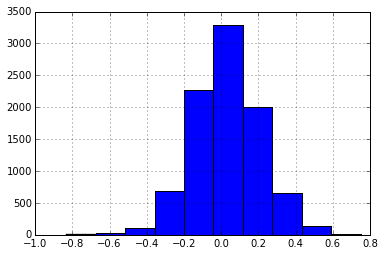

In [25]:
local_attempts_df.right_perc_difference.hist()

In [35]:
p = np.percentile(local_attempts_df.right_perc_difference, 99)

In [37]:
result = local_attempts_df[local_attempts_df.right_perc_difference >= p]
pd.set_option('display.max_rows', len(result))
result

,question_id,question_text,answer_text,US_attempts,non_US_attempts,total_attempts,right_answers_US,right_perc_US,right_answers_non_US,right_perc_non_US,right_perc_difference
9127,9512,Which food is necessary to make huevos rancheros?,Eggs,21,28,49,21,1.000000,7,0.250000,0.750000
5706,5821,What group of people actually elects the presi...,Electoral College,252,56,308,217,0.861111,7,0.125000,0.736111
226,232,Who accused later Supreme Court Justice Claren...,Anita Hill,336,84,420,266,0.791667,7,0.083333,0.708333
8965,9222,What company built the world's largest wagon t...,Radio Flyer,56,35,91,49,0.875000,7,0.200000,0.675000
6036,6163,What movie focuses on a town that outlaws danc...,<em>Footloose</em>,385,98,483,287,0.745455,7,0.071429,0.674026
9070,9376,Who flew the <em>Spirit of St. Louis</em>?,Charles Lindbergh,91,21,112,91,1.000000,7,0.333333,0.666667
1861,1887,Which US president is pictured on a $50 bill?,Ulysses S. Grant,371,112,483,266,0.716981,7,0.062500,0.654481
4938,5040,Which colonial inventor came up with the idea ...,Benjamin Franklin,378,56,434,294,0.777778,7,0.125000,0.652778
3392,3465,"Who was a ""wunnerful, wunnerful"" band leader?",Lawrence Welk,259,77,336,238,0.918919,21,0.272727,0.646192
5264,5374,Which of these US states was not one of the or...,Ohio,273,84,357,196,0.717949,7,0.083333,0.634615
